# Wie gut kennen die Llama-Modelle Distanzen zwischen großen Städten?

In [1]:
import os
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
import itertools
import json

import pandas as pd
pd.set_option('display.max_colwidth', None)

from dotenv import load_dotenv
load_dotenv()

from utils import constants
from utils.pool import query_save_parallel

### Datensatz erstellen

In [2]:
samples_path = './samples/all.csv'
# n = 100 # Anzahl ausgewählten Paare

columns = ['Country', 'City', 'Population', 'Latitude', 'Longitude'] # Spalten, die beachtet werden sollen
dtype = dict(zip(columns, ['object', 'object', 'Int64', 'float64', 'float64'])) # Datentypen der Spalten

In [3]:
if not os.path.exists(samples_path): # wenn die Daten noch nicht existieren:
    # Daten einlesen
    df = pd.read_csv('../data/worldcitiespop.csv', usecols=columns, dtype=dtype)
    
    # Daten filtern:
    # nur Städte mit mehr als 100.000 Einwohnern
    # laut Paper 3.527 (passt)
    df = df[df['Population'] > 100000]

    # Einträge zufällig permutieren
    df = df.sample(frac=1).reset_index(drop=True)

    # Sicherstellen, dass Paare gebildet werden können
    n = df.shape[0]
    even_number = n - n % 2
    df = df[:even_number]

    # Aufteilen in zwei Gruppen mit jeweils even_number / 2 Elementen
    splitter = int(even_number / 2)
    group_1 = df[:splitter]
    group_2 = df[splitter:]

    # Umbenennen und Index zurücksetzen
    group_1 = group_1.rename(columns={
        'Country': 'Country_1',
        'City': 'City_1',
        'Population': 'Population_1',
        'Latitude': 'Latitude_1',
        'Longitude': 'Longitude_1'
    })
    group_1 = group_1.reset_index(drop=True)
    
    group_2 = group_2.rename(columns={
        'Country': 'Country_2',
        'City': 'City_2',
        'Population': 'Population_2',
        'Latitude': 'Latitude_2',
        'Longitude': 'Longitude_2'
    })
    group_2 = group_2.reset_index(drop=True)

    # Gruppen zu Paaren zusammenführen
    groups = pd.concat([group_1, group_2], axis=1)
    print(f'Anzahl der Einträge nach dem Auswählen: {groups.shape[0]}')

    # Speichern der Daten
    groups.to_csv(samples_path, index=False)

# Daten einlesen
samples = pd.read_csv(samples_path, dtype=dtype)
display(samples.head())
print(samples.shape[0])

,Country_1,City_1,Population_1,Latitude_1,Longitude_1,Country_2,City_2,Population_2,Latitude_2,Longitude_2
0,cn,rongcheng,1001985,23.528858,116.364159,ru,angarsk,243161,52.536667,103.886389
1,py,fernando de la mora,120180,-25.316667,-57.600000,ph,cebu,758597,10.311111,123.891667
2,cn,huangzhou,122563,30.450000,114.800000,cn,guiyang,1171633,26.583333,106.716667
3,tr,iskenderun,160046,36.587185,36.173468,au,cairns,154318,-16.923040,145.766251
4,in,azamgarh,116655,26.060000,83.186111,in,amritsar,1092528,31.633056,74.865556


1763


### Distanz zwischen den Städten berechnen

In [4]:
distances = np.empty(samples.shape[0])

for index, row in samples.iterrows():

    try:
        distances[index] = distance.distance((row['Latitude_1'], row['Longitude_1']), (row['Latitude_2'], row['Longitude_2'])).km
    except:
        distances[index] = np.nan

samples = samples.assign(Distance=pd.Series(distances).values)
display(samples[['Country_1', 'City_1', 'Latitude_1', 'Longitude_1', 'Country_2', 'City_2', 'Latitude_2', 'Longitude_2', 'Distance']].head())

,Country_1,City_1,Latitude_1,Longitude_1,Country_2,City_2,Latitude_2,Longitude_2,Distance
0,cn,rongcheng,23.528858,116.364159,ru,angarsk,52.536667,103.886389,3390.045592
1,py,fernando de la mora,-25.316667,-57.600000,ph,cebu,10.311111,123.891667,18335.869385
2,cn,huangzhou,30.450000,114.800000,cn,guiyang,26.583333,106.716667,899.478166
3,tr,iskenderun,36.587185,36.173468,au,cairns,-16.923040,145.766251,12848.309267
4,in,azamgarh,26.060000,83.186111,in,amritsar,31.633056,74.865556,1019.566326


### Llama fragen

In [5]:
DEEPINFRA_API_KEY = os.getenv('DEEPINFRA_API_KEY')

file_name_template = '{model_key}-Instruct-{template_key}{add_country}'
path = './answers/'

queries = itertools.product(constants.models.keys(), constants.templates.keys(), [True, False])
dfs = {}

# Für jede Kombination von LLM, Template und mit/ohne Land
for (model_key, template_key, add_country) in queries:
    file_name = file_name_template.format(model_key=model_key, template_key=template_key, add_country= '-country' if add_country else '')
    file_path = os.path.join(path, file_name + '.csv')

    df = query_save_parallel(constants.models[model_key], constants.templates[template_key], file_path, DEEPINFRA_API_KEY, samples, add_country=add_country, process_number=100)

    model_number = model_key.split('-')[1:]
    df_key = '-'.join(model_number)

    if add_country:
        df_key = df_key + "-country"

    dfs[df_key] = df

Die Datei ./answers/llama-3.1-8B-Instruct-json-country.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.1-8B-Instruct-json.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.1-70B-Instruct-json-country.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.1-70B-Instruct-json.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.1-405B-Instruct-json-country.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.1-405B-Instruct-json.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.3-70B-Instruct-json-country.csv wurde vollständig erstellt!
Die Datei ./answers/llama-3.3-70B-Instruct-json.csv wurde vollständig erstellt!


### Antworten auswerten

In [6]:
def extract_coords_json(df):
    n = df.shape[0]
    distance_llm = np.empty(n)

    for index, row in df.iterrows():
        answer = row['Answers']

        try:
            answer_json = json.loads(answer)
            
            distance_llm[index] = answer_json['distance']
        except:
            distance_llm[index] = np.nan
            
    df = df.assign(DistanceLLM=pd.Series(distance_llm).values)
    return df

In [7]:
for key in dfs.keys():
    dfs[key] = extract_coords_json(dfs[key])
    dfs[key]['Error'] = np.abs(dfs[key]['Distance'] - dfs[key]['DistanceLLM'])

In [8]:
print(str(dfs.keys()))

dict_keys(['3.1-8B-country', '3.1-8B', '3.1-70B-country', '3.1-70B', '3.1-405B-country', '3.1-405B', '3.3-70B-country', '3.3-70B'])


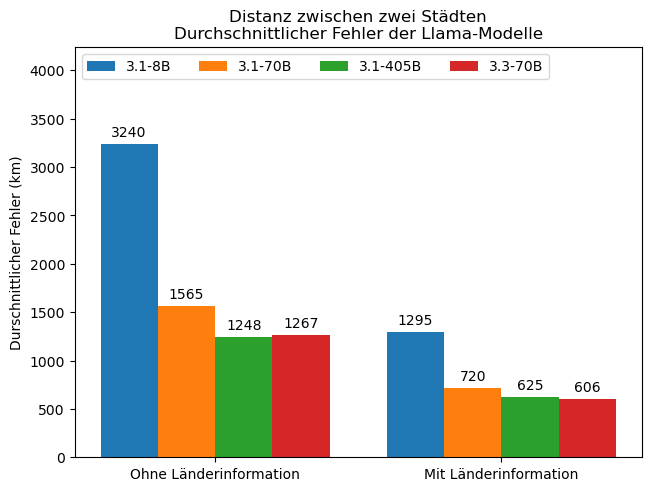

In [9]:
types = ('Ohne Länderinformation', 'Mit Länderinformation')
data = {
    '3.1-8B': [np.nanmean(df['Error']) for df in [dfs['3.1-8B'], dfs['3.1-8B-country']]],
    '3.1-70B': [np.nanmean(df['Error']) for df in [dfs['3.1-70B'], dfs['3.1-70B-country']]],
    '3.1-405B': [np.nanmean(df['Error']) for df in [dfs['3.1-405B'], dfs['3.1-405B-country']]],
    '3.3-70B': [np.nanmean(df['Error']) for df in [dfs['3.3-70B'], dfs['3.3-70B-country']]],
}

x = np.arange(len(types))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

max_value = 0

for attribute, measurement in data.items():
    max_value = np.max([max_value] + measurement)

    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt = lambda i : int(np.round(i, 0)))
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Durschnittlicher Fehler (km)')
ax.set_title('Distanz zwischen zwei Städten\nDurchschnittlicher Fehler der Llama-Modelle')
ax.set_xticks(x + width * 1.5, types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, max_value + 1000)

plt.savefig('./results/distances.pdf')
plt.show()

# p-Werte

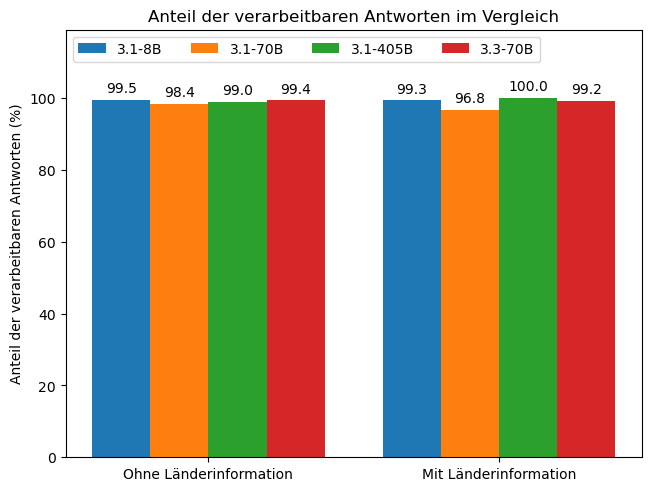

Original: 99.06 +/- 0.42
Country: 98.82 +/- 1.23


In [10]:
def get_p(keys):
    # Der prozentuale Anteil der Antworten, die korrekt ausgewertet werden konnten
    ns = np.array([dfs[key].shape[0] for key in keys])
    nans = np.array([dfs[key]['Error'].isna().sum() for key in keys])
    percentages = (ns - nans) / ns * 100
    return percentages

types = ('Ohne Länderinformation', 'Mit Länderinformation')
data = {
    '3.1-8B': get_p(['3.1-8B', '3.1-8B-country']),
    '3.1-70B': get_p(['3.1-70B', '3.1-70B-country']),
    '3.1-405B': get_p(['3.1-405B', '3.1-405B-country']),
    '3.3-70B': get_p(['3.3-70B', '3.3-70B-country']),
}

x = np.arange(len(types))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

max_value = 0

for attribute, measurement in data.items():
    max_value = np.max([max_value] + measurement)

    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt = lambda i : np.round(i, 1))
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anteil der verarbeitbaren Antworten (%)')
ax.set_title('Anteil der verarbeitbaren Antworten im Vergleich')
ax.set_xticks(x + width * 1.5, types)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 119)

plt.savefig('./results/dist-p.pdf')
plt.show()

original_values = list()
country_values = []

for (original, country) in data.values():
    original_values.append(original)
    country_values.append(country)
    
print(f"Original: {round(np.mean(original_values), 2)} +/- {round(np.std(original_values), 2)}")
print(f"Country: {round(np.mean(country_values), 2)} +/- {round(np.std(country_values), 2)}")

# Standardabweichung

In [11]:
keys = dfs.keys()

for key in keys:
    df = dfs[key]
    std = np.nanstd(df['Error'])
    print(key, round(std, 1))

3.1-8B-country 1304.4
3.1-8B 3697.7
3.1-70B-country 840.9
3.1-70B 2484.1
3.1-405B-country 749.5
3.1-405B 2266.4
3.3-70B-country 616.2
3.3-70B 2201.4
